#  Daily Predictive Model for Crashes at Red Light Intersections

We will create a tree based model to predict the DAILY number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
    - speed limit
    - volume of traffic
    - region
    - lanes/ways/turns/split/exit etc.
- violations (may want a violations independent model)
- red light cam present

This time we will look at whole city, and use only global variables for city.

In [1]:

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import plotly_express as px
import plotly

import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from modules.myfuncs import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor



In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db



We will try to get data that is daily for all of the above info.  

In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('all_days',), ('daily_covid',), ('all_hours',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	injuries_total
	injuri

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [4]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4))


1215.75


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [5]:
# This one groups by day for the whole city

all_df = pd.read_sql_query('''
WITH v AS(SELECT d.year,
            CAST(d.month as TEXT) as month,
            d.day,
            d.intersection,
            SUM(dv.violations) as violations,
            dv.weekday,
            d.datetime,
            COUNT(DISTINCT dv.intersection) as n_intersection

    FROM all_hours as d

    LEFT JOIN daily_violations as dv
        ON d.year = dv.year
        AND d.month = dv.month
        AND d.day = dv.day
        AND d.intersection = dv.intersection
    GROUP BY d.year, d.month, d.day

    ), 

    ic AS(SELECT intersection,
                 region_id
        FROM intersection_cams
    ),

    cg AS(SELECT year,
                 month,
                 day,
                 region_id,
                 (100 - AVG(quantile_speed))/100 as congestion

            FROM hourly_congestion
            GROUP BY year, month, day  

        ),

    cr AS(SELECT SUM(injuries_total) AS injuries,
                year,
                month,
                day,
                COUNT(DISTINCT crash_record_id) as n_crash,
                SUM(COALESCE(injuries_total,0)) AS injuries,
                SUM(injuries_fatal) AS injuries_fatal,
                SUM(injuries_incapacitating) AS injuries_incapacitating
         FROM signal_crashes
         GROUP BY year, month, day
        ),

    wx AS(SELECT MAX(temp) AS temp,
                (SUM(snow_1h) + SUM(rain_1h)) AS precip,
                SUM(snow_1h) AS snow_1h,
                SUM(rain_1h) AS rain_1h,
                year,
                month,
                day
        FROM hourly_weather
        GROUP BY year, month, day
        ),
        
    cov AS(SELECT strftime('%m',lab_report_date) AS month,
                strftime('%Y',lab_report_date) AS year,
                strftime('%d',lab_report_date) AS day,
                lab_report_date,
                cases_total
            FROM daily_covid as dc
            GROUP BY year, month, day
            )

    SELECT  v.n_intersection,
            v.violations, 
            v.year,
            v.month,
            v.day,
            v.datetime,
            CAST(v.weekday AS TEXT) AS weekday,

            cr.injuries,
            cr.n_crash,
            cr.injuries_fatal,
            cr.injuries_incapacitating,


            MAX(wx.temp) as temp,
            MAX(wx.precip) as precip,
            MAX(wx.snow_1h) as snow,
            MAX(wx.rain_1h) as rain,

            cg.congestion,
            
            cov.cases_total as covid_cases



    FROM v
    LEFT JOIN wx
        ON wx.year = v.year
        AND wx.month = v.month
        AND wx.day = v.day
    LEFT JOIN cg
        ON cg.year = v.year
        AND cg.month = v.month
        AND cg.day = v.day
    LEFT JOIN cov
        ON cov.year = v.year
        AND cov.month = v.month
        AND cov.day = v.day
    LEFT JOIN cr
        ON cr.year = v.year
        AND cr.month = v.month
        AND cr.day = v.day
    WHERE v.datetime >= \'2017-09-01\' 
        AND v.datetime <= \'2020-12-31\'
    GROUP BY v.year, v.month, v.day
    ORDER BY v.datetime
                                    ''', conn)


In [6]:
print(all_df.info())
all_df.tail()

all_df.congestion.fillna(all_df.congestion.mean(), inplace=True)
all_df.covid_cases = all_df.covid_cases.fillna(0).astype(int)
all_df.dropna(subset=['violations'], inplace=True)

all_df.year = all_df.year.astype(str)
all_df.year = all_df.year.astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 17 columns):
n_intersection             1217 non-null int64
violations                 1217 non-null int64
year                       1217 non-null int64
month                      1217 non-null object
day                        1217 non-null int64
datetime                   1217 non-null object
weekday                    1191 non-null object
injuries                   1217 non-null int64
n_crash                    1217 non-null int64
injuries_fatal             1217 non-null int64
injuries_incapacitating    1217 non-null int64
temp                       1217 non-null float64
precip                     1217 non-null float64
snow                       1217 non-null float64
rain                       1217 non-null float64
congestion                 1202 non-null float64
covid_cases                91 non-null object
dtypes: float64(5), int64(8), object(4)
memory usage: 161.8+ KB
None


## Drop unnecessary features

In [7]:
y = all_df['n_crash'].fillna(0)
y = y.astype(int)

drop_cols = ['datetime', 'day', 'injuries', 'injuries_fatal', 
             'injuries_incapacitating', 'n_crash']


X = all_df.drop(columns=drop_cols) 

## Drop additional features identified in Boruta

In [8]:
X_ = pd.get_dummies(X)

boruta_drop = ['rain', 'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4',
               'month_5', 'month_7', 'month_8', 'month_9', 'weekday_0', 'weekday_1', 'weekday_2',
               'weekday_3','weekday_4', 'weekday_6',]

#X_ = X_.drop(columns=boruta_drop) # Use the later Boruta feature elimination here instead of direct filter
X_.columns
X_.head()

,n_intersection,violations,temp,precip,snow,rain,congestion,covid_cases,year_2017,year_2018,...,month_7,month_8,month_9,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,145,40896,294.15,0.00,0.0,0.00,0.604243,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,144,38952,297.15,0.00,0.0,0.00,0.505622,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2,140,35856,302.15,6.60,0.0,6.60,0.392455,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,143,30192,303.15,1.12,0.0,1.12,0.453649,0,1,0,...,0,0,1,1,0,0,0,0,0,0
4,145,32784,297.15,0.00,0.0,0.00,0.602013,0,1,0,...,0,0,1,0,1,0,0,0,0,0


### Train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=0)

## Baseline Tree

In [10]:
# Instantiate and fit a DecisionTreeClassifier
tree_reg = DecisionTreeRegressor(random_state=0) 
tree_reg.fit(X_train, y_train)
tree_reg.score(X_test, y_test)

-0.25171529788642943

In [11]:
tree_reg.feature_importances_

array([0.0317252 , 0.19083729, 0.15701616, 0.0327725 , 0.00318183,
       0.08432992, 0.13161651, 0.00159366, 0.00091173, 0.01077181,
       0.00062837, 0.11360765, 0.00508837, 0.0087685 , 0.01134876,
       0.01191698, 0.0063423 , 0.00917187, 0.05884265, 0.00153098,
       0.00951934, 0.00923126, 0.00243741, 0.00347971, 0.01432119,
       0.00935116, 0.01034072, 0.00781811, 0.00662967, 0.01209049,
       0.04277788])

In [13]:
def plot_feature_importances(model, X_train):
    n_features = X_train.shape[1]
    
    importance = model.feature_importances_
    features = X_train.columns.values
    df = pd.DataFrame()
    df['imp'] = importance
    df['feat'] = features
    df = df.sort_values(by=['imp'], ascending=True)

    plt.figure(figsize=(8,len(df)//2))
    plt.barh(range(len(df)), df['imp'], align='center', color='purple') 
    plt.yticks(np.arange(len(df)), df['feat'])
    plt.xticks(rotation=45)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    return list(df['feat'])
    
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [14]:
# SKIP THIS CELL UNLESS PERFORMING GRID Search



# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [5, 6, 8],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [200, 400, 800]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)
# print(grid_search.best_estimator_)

In [15]:
# Instantiate and fit a RandomForestClassifier with best params
# this is here to save time
forest_reg = RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=20,
                                             max_features=10,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=500, n_jobs=None,
                                             oob_score=True, random_state=0,
                                             verbose=0, warm_start=False)



print("Base Model:")
base_accuracy = evaluate(tree_reg, X_test, y_test)
print('r2 Score: {:.2f}'.format(tree_reg.score(X_test, y_test)))
score = cross_val_score(tree_reg, X_train, y_train, cv=5,)
print('Cross val score: {:.2f}'.format(score.mean()))


print("\nGrid CV Best:")
forest_reg.fit(X_train, y_train)
grid_accuracy = evaluate(forest_reg, X_test, y_test)
print('r2 Score: {:.2f}'.format(forest_reg.score(X_test, y_test)))
score = cross_val_score(forest_reg, X_train, y_train, cv=5,)
print('Cross val score: {:.2f}'.format(score.mean()))


Base Model:
Model Performance
Average Error: 9.1270.
Accuracy = 76.61%.
r2 Score: -0.25
Cross val score: -0.47

Grid CV Best:
Model Performance
Average Error: 6.8880.
Accuracy = 81.74%.
r2 Score: 0.33
Cross val score: 0.31


['month_7',
 'year_2017',
 'month_11',
 'month_9',
 'month_6',
 'month_8',
 'month_2',
 'month_10',
 'weekday_2',
 'month_12',
 'weekday_3',
 'weekday_1',
 'weekday_0',
 'month_5',
 'year_2018',
 'month_1',
 'covid_cases',
 'month_3',
 'weekday_5',
 'snow',
 'year_2019',
 'weekday_4',
 'weekday_6',
 'month_4',
 'rain',
 'precip',
 'n_intersection',
 'year_2020',
 'temp',
 'violations',
 'congestion']

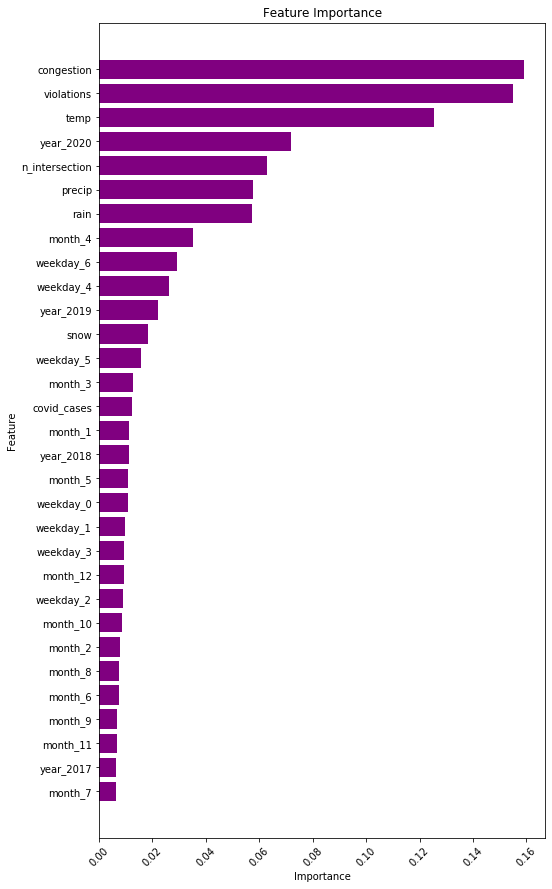

In [16]:
plot_feature_importances(forest_reg, X_train)

## Feature importance

<Figure size 432x432 with 0 Axes>

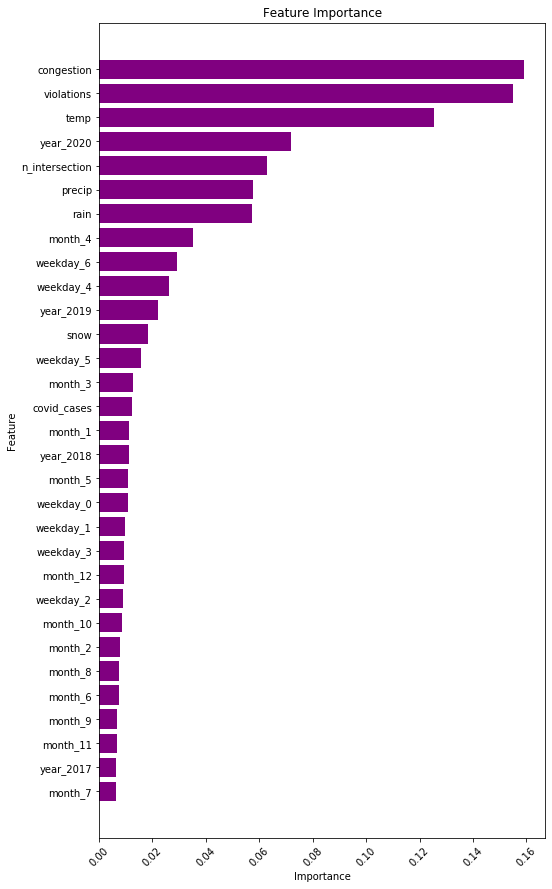

In [18]:
def plot_feature_importances(model, X_train):
    n_features = X_train.shape[1]
    
    importance = model.feature_importances_
    features = X_train.columns.values
    df = pd.DataFrame()
    df['imp'] = importance
    df['feat'] = features
    df = df.sort_values(by=['imp'], ascending=True)

    plt.figure(figsize=(8,len(df)//2))
    plt.barh(range(len(df)), df['imp'], align='center', color='purple') 
    plt.yticks(np.arange(len(df)), df['feat'])
    plt.xticks(rotation=45)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    return list(df['feat'])



plt.figure(figsize=[6,6])

features = plot_feature_importances(forest_reg, X_train)


In [19]:
if input('Do you want to overwrite X with auto selected features?').upper() in ["Y", "YES"]:
    # define Boruta feature selection method
    feat_selector = BorutaPy(forest_reg, n_estimators='auto', verbose=1, random_state=1)

    # find all relevant features
    feat_selector.fit(X.values, y.values)

    # # check selected features
    feat_selector.support_

    # # check ranking of features
    feat_selector.ranking_

    # # call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(X.values)
    print(forest_reg.feature_importances_)
    
    # zip my names, ranks, and decisions in a single iterable
    feature_ranks = list(zip(X.columns, 
                             feat_selector.ranking_, 
                             feat_selector.support_))

    # iterate through and print out the results
    for feat in feature_ranks:
        print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Do you want to overwrite X with auto selected features?n


In [20]:
print('{:20}{:20}'.format("Feature", 'Importance'))

for feature, importance in sorted(zip(X.columns, forest_reg.feature_importances_), key=lambda x: x[1], reverse=True):
    print('{:20}{:.3f}'.format(feature, importance))



Feature             Importance          
precip              0.159
violations          0.155
year                0.125
n_intersection      0.063
month               0.058
temp                0.057
covid_cases         0.022
weekday             0.019
snow                0.012
congestion          0.011
rain                0.006


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluating the Algorithm

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

pred = forest_reg.predict(X_test)

print('Mean Absolute Error: {:.1f}'.format(mean_absolute_error(y_test, pred))) 
print('Mean Absolute Percentage: {:.1%}'.format(mean_absolute_percentage_error(y_test, pred)))
print('Mean Squared Error: {:.0f}'.format(mean_squared_error(y_test, pred)))
print('Root Mean Squared Error: {:.1f}'.format(np.sqrt(mean_squared_error(y_test, pred))))

Mean Absolute Error: 6.9
Mean Absolute Percentage: 18.3%
Mean Squared Error: 78
Root Mean Squared Error: 8.8


count    1217.000000
mean       40.693509
std        10.646097
min         8.000000
25%        34.000000
50%        41.000000
75%        47.000000
max        84.000000
Name: n_crash, dtype: float64


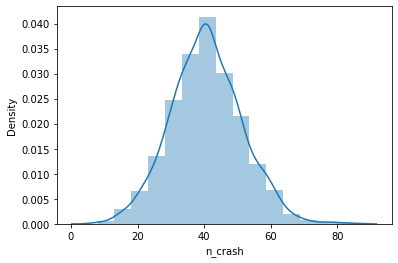

In [22]:
print(y.describe())
sns.distplot(y, bins=15)


In [23]:
pred = forest_reg.predict(X_)

In [24]:
all_df['datetime'] = pd.to_datetime(all_df['datetime'])


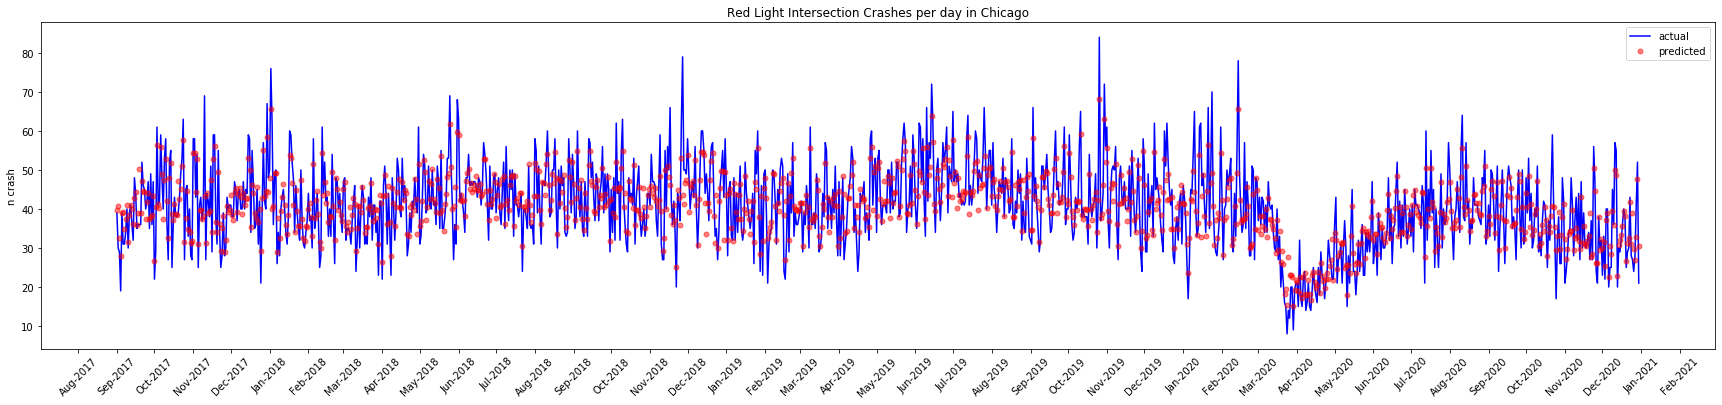

In [25]:
# Use datetime for creating date objects for plotting
# Import necessary packages
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import pandas as pd



# Plot the actual values
fig, ax = plt.subplots(figsize=[30,6])
ax.plot(all_df['datetime'], y, 'b-', label = 'actual')


plt.xticks(rotation=45)


# # Plot the predicted values
plt.plot(all_df['datetime'], pred, 'r.', markersize=10, alpha=0.5, label = 'predicted')
plt.legend()

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Graph labels
plt.ylabel('n crash')
plt.title('Red Light Intersection Crashes per day in Chicago')

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))


plt.show()

In [26]:
import plotly.express as px

all_df2 = all_df.copy()
all_df2['pred'] = pred
all_df2['revenue'] = all_df2['n_crash'] * 100

fig = px.line(all_df2, x='datetime', y='n_crash', width=1000, height=400,
             hover_data=["violations", "temp", 'precip', 'weekday'],
              title='Daily Red Light Crashes Model',
             )
fig.add_scatter(x=all_df2.datetime, y=all_df2.pred, mode='markers', name='model predict')

fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="left",
                            x=0.01),
                  yaxis_title="Crashes",
                 )

fig.update_layout(margin=dict(
                                        l=0, #left margin
                                        r=0, #right margin
                                        b=0, #bottom margin
                                        t=0  #top margin
                                        )
                    )
                    


fig.write_html("daily_signal_crashes.html")


# PART 2: Let's do same with injuries

In [27]:
y = all_df['injuries'].fillna(0).astype(int)

drop_cols = ['datetime', 'day', 'injuries', 'injuries_fatal', 
             'injuries_incapacitating', 'n_crash']

X = all_df.drop(columns=drop_cols) 

In [28]:
boruta_drop = ['month_9',
                 'month_8',
                 'year_2017',
                 'weekday_1',
                 'month_7',
                 'month_10',
                 'weekday_3',
                 'weekday_2',
                 'weekday_0',
                 'month_11',
                 'month_12',
                 'month_6',
                 'month_5',
                 'year_2018',]

X = pd.get_dummies(X)
#X = X.drop(columns=boruta_drop)

## Train test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Baseline Tree

In [30]:
# Instantiate and fit a DecisionTreeClassifier
#np.random.seed(337)

tree_reg = DecisionTreeRegressor(random_state = 0) 
tree_reg.fit(X_train, y_train)
print(tree_reg.score(X_test, y_test))

pred = tree_reg.predict(X)
mse = mean_squared_error(y, pred)
np.sqrt(mse)

-0.7776104224891371


4.1031282532493405

In [31]:
tree_reg.feature_importances_


array([9.84025784e-02, 2.34680995e-01, 2.09703638e-01, 5.79210567e-02,
       7.19453294e-03, 4.62444205e-02, 1.67664334e-01, 5.11954853e-03,
       2.18642023e-04, 1.54712464e-02, 6.83583977e-03, 1.44176861e-02,
       3.87337647e-03, 1.08829356e-03, 5.73824530e-03, 4.62734439e-04,
       8.39737461e-03, 1.01799952e-02, 1.59303830e-02, 6.33117375e-03,
       4.16423398e-03, 9.18101874e-03, 6.02480240e-04, 9.37614172e-03,
       5.43437955e-03, 7.47139886e-03, 1.25968663e-02, 1.76171605e-02,
       6.98626668e-03, 4.23818473e-03, 6.45577380e-03])

In [32]:
# SKIP THIS CELL UNLESS YOU WANT TO DO THE LONG SEARCH AGAIN.  BEST RESULT IS IN NEXT CELL
# from sklearn.model_selection import GridSearchCV


# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [10, 20, 30],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 12],
#     'n_estimators': [500, 750, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)

# # RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
# #                       max_features=12, max_leaf_nodes=None,
# #                       min_impurity_decrease=0.0, min_impurity_split=None,
# #                       min_samples_leaf=3, min_samples_split=12,
# #                       min_weight_fraction_leaf=0.0, n_estimators=500,
# #                       n_jobs=None, oob_score=False, random_state=None,
# #                       verbose=0, warm_start=False)

# best_grid = grid_search.best_estimator_
# print(best_grid)

# print("Base Model:")
# base_accuracy = evaluate(tree_reg, X_test, y_test)

# print("\nGrid CV Best:")
# grid_accuracy = evaluate(best_grid, X_test, y_test)

In [33]:
# Instantiate and fit a RandomForest regression
forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=0,
                      verbose=0, warm_start=False)



forest.fit(X_train, y_train)
forest.score(X_test, y_test)


0.07223139791492961

In [34]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy



In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluating the Algorithm

def mean_absolute_percentage_error(y_true, y_pred): 
    # Calculate MAPE (it was removed from sklearn)
    try:
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs(y_true - y_pred) / y_true)
    except:
        return 'inf'

pred = forest.predict(X_test)

print('Mean Absolute Error: {:.1f}'.format(mean_absolute_error(y_test, pred))) 
print('Mean Absolute Percentage: {:.1%}'.format(mean_absolute_percentage_error(y_test, pred)))
print('Mean Squared Error: {:.0f}'.format(mean_squared_error(y_test, pred)))
print('Root Mean Squared Error: {:.1f}'.format(np.sqrt(mean_squared_error(y_test, pred))))

Mean Absolute Error: 5.3
Mean Absolute Percentage: inf%
Mean Squared Error: 44
Root Mean Squared Error: 6.6


## Results
Using a random forest model, we can predict the number of daily crashes at intersections.
R-squared value is around 0.30, making this a moderately good fit.

The injury data did was very low (less than 0.10), and does not seem useful as a prediction tool due the noise/volatility in the injury data.
